### Эксперименты с трансформером

В этом ноутбуке будут показано сравнение трансформера с его небольшими модификациями. Здесь использовался такой же трансформер, как и в оригинальной [статье](https://arxiv.org/abs/2311.12424) - это nano_gpt2 от Andreyj Karpathy.



Реализации трансформеров в файлике **transformers.py**
Проверял я 3 вида трансформера в задаче регрессии: обычный, looped (вида A A A ... ), looped с обрезанным инпутом в себя (брал только 10 последних токенов), cycled (A B C A B C A ...)

Сколько успел *:)* я поперебирал параметры для новоиспечённых трансформеров.

#### Для looped трансформера
* число петель: 12, 24, 48
* эпох: 100, 50, 25
соответственно

#### Для обрезанного looped трансформера:
* число петель: 12, 24, 48
* эпох: 100, 50, 25
* число последних токенов, которые берём: 10

#### Для cycled трансформера:
* длина цикла: 2
* число циклов: 5

У всех трансформеров было 24 слоя.

In [236]:
import torch
from pipelines import start_training

from config import Args

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device = {device}')

args = [
    Args(name='gpt2_base', family="gpt2", n_layer=24, epochs=50),
    Args(name='gpt2_loop_24_50', family="gpt2_loop", n_loop_window=24, epochs=50),
    Args(name='gpt2_loop_12_100', family="gpt2_loop", n_loop_window=12, epochs=100),
    Args(name='gpt2_loop_48_25', family="gpt2_loop", n_loop_window=48, epochs=25),
    Args(name='gpt2_cutted_24_50', family="gpt2_residual_n", n_loop_window=24, epochs=50),
    Args(name='gpt2_cutted_12_100', family="gpt2_residual_n", n_loop_window=12, epochs=100),
    Args(name='gpt2_cutted_48_25', family="gpt2_residual_n", n_loop_window=48, epochs=25),
    Args(name='gpt2_cyclic_5_2_50', family="gpt2_cyclic", n_loop_window=5, block_size=2, epochs=50),
    Args(name='gpt2_cyclic_2_5_50', family="gpt2_cyclic", n_loop_window=2, block_size=5, epochs=50)
]

for arg in args:
    print(f'Start {arg.name}')
    start_training(arg, device)


/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/pavelvasilev/PycharmProjects/looped_transformers/pipelines.py:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Device = cpu
Start gpt2_base
number of parameters: 1.20M


  0%|                                                    | 0/50 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [240]:
data = torch.load('training_info/training_info_gpt2_cyclic_5_2_50.pt')
errors = data['losses']
val_errors = data['avg_losses']
val_scores = data['val_scores']
weight_norms = data['weight_norms']
gradient_norms = data['gradient_norms']
gradients = data['gradients']

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/1581533783.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('training_info/training_inf

In [242]:


def plot(data, x_name, y_name, label):
    plt.plot(data, label=label)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_data(data_arr, x_name, y_name, labels):
    num_plots = len(data_arr)
    plt.figure(figsize=(15, 10))
    fig, ax = plt.subplots()
    for i, data in enumerate(data_arr):
        ax.plot(data, label=labels[i])
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.legend()
    ax.grid(True)
    plt.show() 

Выведем лоссы всех моделей

In [245]:
import os
from os.path import isfile, join
training_info_path = 'training_info'
files = [f for f in os.listdir(training_info_path) if isfile(join(training_info_path, f))]


def get_data(files, filter_str=None):
    labels = [os.path.splitext(f)[0] for f in files]
    data_arr = []
    result_labels = []
    for f in files:
        label = os.path.splitext(f)[0]
        if filter_str is None or filter_str in label:
            data = torch.load(os.path.join(training_info_path, f))
            data_arr += [data]
            result_labels += [label]
    return data_arr, result_labels


def parse_data(data_arr):
    losses = [data['losses'] for data in data_arr]
    avg_losses = [data['avg_losses'] for data in data_arr]
    val_scores = [data['val_scores'] for data in data_arr]
    weight_norms = [data['weight_norms'] for data in data_arr]
    gradient_norms = [data['gradient_norms'] for data in data_arr]
    gradients = [data['gradients'] for data in data_arr]
    return losses, avg_losses, val_scores, weight_norms, gradient_norms, gradients


Обычный трансформер:

In [248]:
def show(transformer_name_substring=None):
    data_arr, labels = get_data(files, transformer_name_substring)
    losses, avg_losses, val_scores, weight_norms, gradient_norms, gradients = parse_data(data_arr)
    plot_data(avg_losses, 'Epochs', 'Loss', labels)

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/2344198585.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(training_info

<Figure size 1500x1000 with 0 Axes>

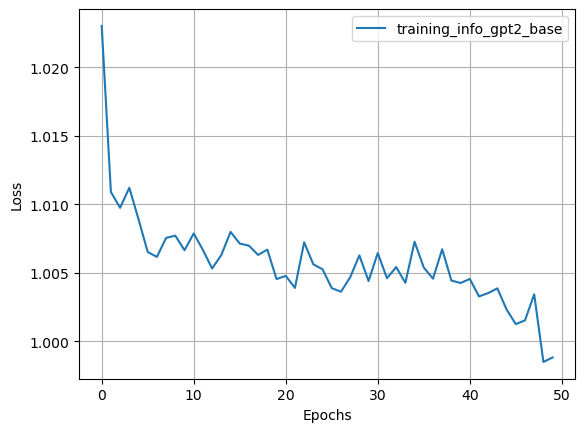

In [250]:
show('base')

Looped трансформер (первое число означает число петель, второе - число эпох)

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/2344198585.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(training_info

<Figure size 1500x1000 with 0 Axes>

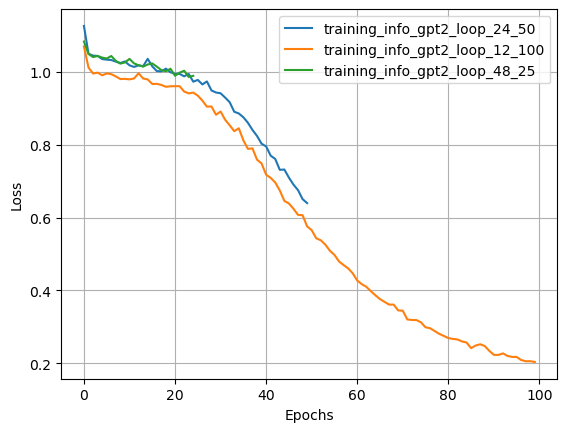

In [253]:
show('loop')

Cutted трансформер (первое число означает число петель, второе - число эпох):

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/2344198585.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(training_info

<Figure size 1500x1000 with 0 Axes>

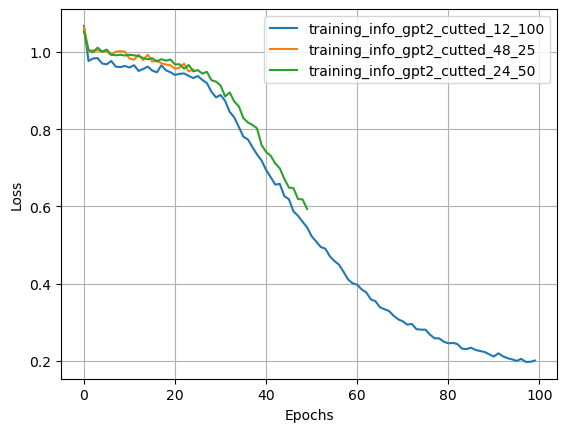

In [256]:
show('cutted')

Зацикленный трансформер (первое число - количество итераций прохода *цикла*, второе - длина цикла, третье - число эпох):

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/2344198585.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(training_info

<Figure size 1500x1000 with 0 Axes>

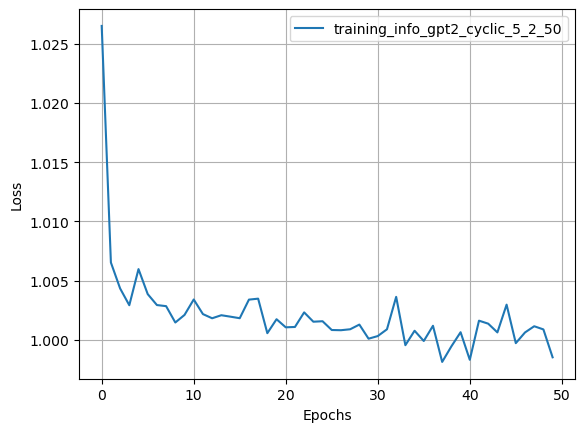

In [259]:
show('cyclic')

Все вместе:

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/2344198585.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(training_info

<Figure size 1500x1000 with 0 Axes>

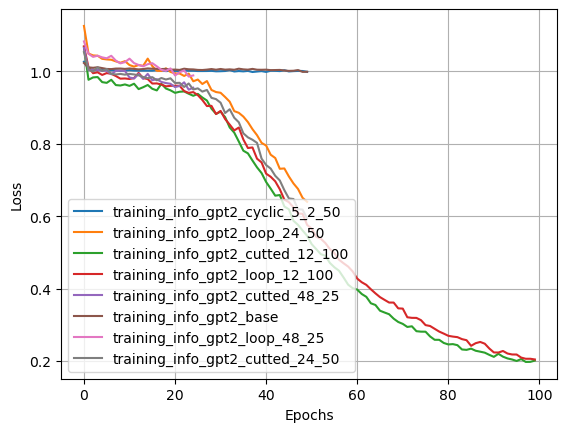

In [262]:
show()

### И так же посмотрим в разрезе количества эпох обучения
25:

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/2344198585.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(training_info

<Figure size 1500x1000 with 0 Axes>

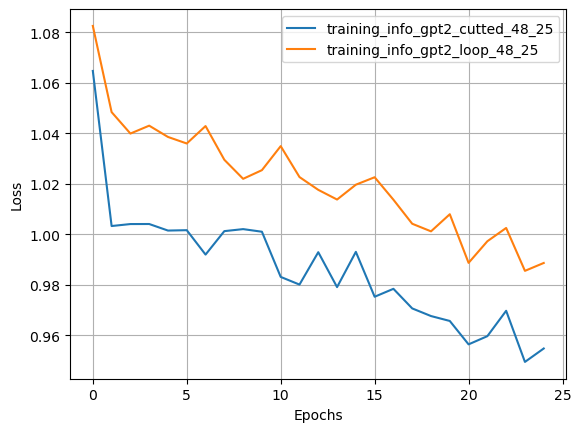

In [265]:
show('25')

50:

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/2344198585.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(training_info

<Figure size 1500x1000 with 0 Axes>

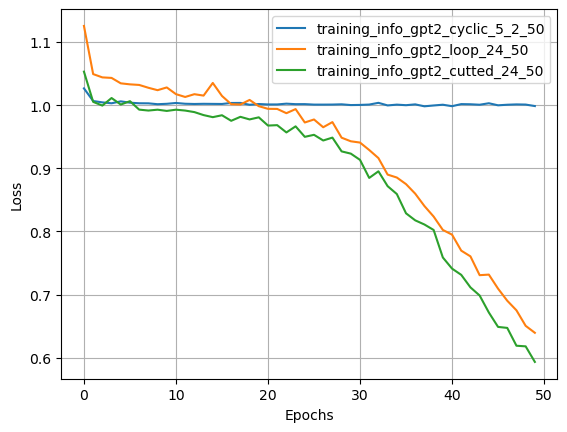

In [268]:
show('50')

100:

/var/folders/qc/ksg5z85x3qq7vc2dc22bpmwm0000gn/T/ipykernel_53450/2344198585.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(training_info

<Figure size 1500x1000 with 0 Axes>

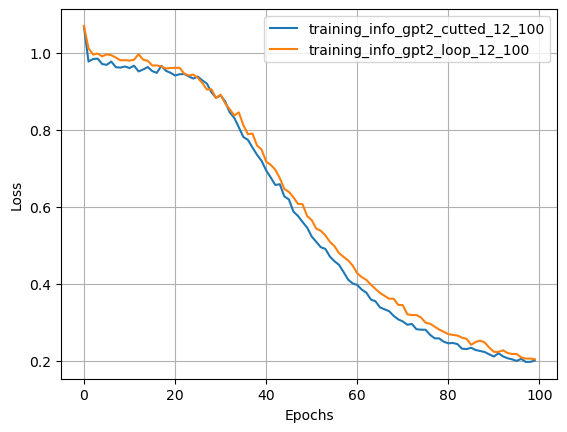

In [271]:
show('100')

### Анализ

Видно, что импакт обучения обычного трансформера быстро заканчивается. Парвда я здесь обучил обычный трансформер всего с одним набором гиперпараметров, однако в статье приложены графики, подтверждающие мои слова на разных наборах гиперпараметров.
В свою очередь, looped трансформер достаточно приятно уменьшает лосс с увеличением количества эпох (ошибка убывает подобно перевернутому логарифму).
Обрезав инпуты, я увидел, что вообще-то качество не поменялось (или поменялось совсеееем незначительно). Длина входной последовательности в моих экспериментах была равна 128, в то время как в cutted трансформере я использовал лишь 10 последних токенов. Я могу объяснить такое поведение тем, что поскольку выходы трансформера мы суём в тот же трансформер, то контекст он не теряет, поскольку фактически мы всё время взаимодействуем с одними и теми же весами.

Я пытался сделать так, чтобы время обучения у всех трансформеров было примерно одинаковым, чтобы они "на равных" соревновались. Тем не менее, получилось так, что cyclic трансформер обучался гораздо дольше остальных. Также он занимал гораздо больше оперативной памяти, и в итоге результаты показал не лучше чем обычный трансформер. Я связываю это с тем, что поскольку всё-таки трансформер не один, хоть он и циклический, прокидывание градиента становится тяжёлым, ведь слоёв становится кратно больше. А оперативки ест больше понятно почему - больше трансформеров и укаждого свои веса, т.е. оперативки больше в столько раз, сколько длина цикла.
Если отвечать на вопрос, можно ли делать меньше циклов обучения, то нет нельзя - его качество не лучше одного трансформера (либо я что-то не так сделал *:)*)
